# 五个经典设施选址模型的详解及其实践：Python调用Gurobi实现

参考文献：
Ho-Yin Mak and Zuo-Jun Max Shen (2016), “Integrated Modeling for Location Analysis”, Foundations and Trends in Technology, Information and Operations Management: Vol. 9, No. 1-2, pp 1–152. DOI: 10.1561/0200000037

### 1、覆盖问题（Covering Model）

假设有一个需求点的位置集合和一个设施的位置集合，且已知每个设施的服务范围。在满足**覆盖所有顾客需求点**的前提下，选取若干个点建造设施，以使得建设总成本最小。

- 参数
$$
\begin{align*}
	&I\text{：需求位置集合}
	\\
	&J\text{：潜在设施位置集合}
	\\
	&f_i:\text{在}i\text{建造设施的成本}
	\\
	&a_{i,j}=\begin{cases}
		1, \text{在}j\text{点建造的设施可以覆盖需求}i\\
		0\\
	\end{cases}
\end{align*}
$$
- 决策变量
$$
\begin{align*}
	&X_{i}=\begin{cases}
		1, \text{在}i\text{点建造设施}\\
		0\\
	\end{cases}
\end{align*}
$$

- IP模型
$$
\begin{align*}
	\min \; & \sum_{j\in {J}}{f_jX_j}\\
	s.t. \; & \sum_{j\in {J}}
		{\begin{array}{c}
			a_{i,j}X_j\geqslant 1\\
		\end{array}} && \forall i\in I
	\\
	& X_j\in \left\{ 0,1 \right\} && \forall j \in J
\end{align*}
$$

In [36]:
from gurobipy import *
import random
import numpy as np

# Parameters
num_points = 5                        # I: set of the demand points
num_facilities = 10                   # J: set of possible facility location
setup_cost = [3,2,3,1,3,3,4,3,2,4]    # f: cost of locate each facility
np.random.seed(0)
cover = np.random.randint(2,size=(num_points,num_facilities)) # a：facility at j can cover point i

# Create a new model
m = Model("Covering Model")

# Create variables
select = m.addVars(num_facilities, vtype=GRB.BINARY, name='Select') # X

# Add constraints
m.addConstrs((quicksum((cover[i,j] * select[j]) for j in range(num_facilities)) >= 1 for i in range(num_points)), name='Cover')

# Set objective
m.setObjective(select.prod(setup_cost), GRB.MINIMIZE)

m.optimize()

for v in m.getVars():
    if v.x > 0 :
        print('%s %g' % (v.varName, v.x))

print('obj:%g' % m.objVal)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 5 rows, 10 columns and 30 nonzeros
Model fingerprint: 0x0f7f480f
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 6.0000000
Presolve removed 5 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 2: 3 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
Select[3] 1
Select[8] 1
obj:3


### 2、最大覆盖问题（Maximum Covering Model）

假设有一个需求点的位置集合，且已知每个设施的服务范围、每个需求点的客户人数以及设施总数。在设施总数一定的前提下，**选取建造设施的位置**以及**能够被设施服务到的站点**，以使得被服务到的客户人数最大。

- 参数
$$
\begin{align*}
	&I\text{：需求位置集合}
	\\
	&P\text{：设施总数}
	\\
	&h_i:\text{在}i\text{顾客人数}
	\\
	&a_{i,j}=\begin{cases}
		1, \text{在}j\text{点建造的设施可以覆盖需求}i\\
		0\\
	\end{cases}
\end{align*}
$$
- 决策变量
$$
\begin{align*}
	&X_{i}=\begin{cases}
		1, \text{在}i\text{点建造设施}\\
		0\\
	\end{cases}\\
    &Z_{j}=\begin{cases}
		1, \text{点}j\text{能够被服务到}\\
		0\\
	\end{cases}
\end{align*}
$$

- IP模型
$$
\begin{align*}
	\max \; & \sum_{i\in {I}}{h_iZ_i}\\
	s.t. \; & \sum_{i\in I}{X_i=P_i}\\
		& \sum_{j\in J}{\begin{array}{c}
		a_{i,j}X_j\geqslant Z_i\\
		\end{array}} && \forall i \in I\\
		& X_i, Z_i\in \left\{ 0,1 \right\} && \forall i \in I

\end{align*}
$$

In [37]:
from gurobipy import *
import random
import numpy as np

# Parameters
# Facility is the scarce resources, so num_points is bigger than num_located
# Set of possible facility location is the set of the demand points ( J == I )
num_points = 10 # I: set of the demand points
num_located = 5 # P: number of facility

np.random.seed(0)
num_people = np.random.randint(6,size = num_points)  # h
cover = np.random.randint(2,size=(num_points,num_points)) # a

m = Model("Maximum Covering Model")

# Create variables，返回一个tupedict对象，key是序号，value是取值
select = m.addVars(num_points, vtype=GRB.BINARY, name='Select')  # X
serve = m.addVars(num_points, vtype=GRB.BINARY, name='Serve')    # Z

# Add constraints
m.addConstrs((quicksum((cover[(i,j)] * select[j]) for j in range(num_points)) >= serve[i] for i in range(num_points)), name='Cover_before_serve')
m.addConstr((quicksum(select) == num_located), name='Num_limit')  # addConstrs --> error: Missing Constraint Index

# Set objective
m.setObjective(quicksum(serve[i]*num_people[i] for i in range(num_points)), GRB.MAXIMIZE)

m.write("lp--Max_Covering_Problem.lp")
m.optimize()

# Print results
selected = []
served = []
for i in select.keys():
    if select[i].x > 0:
        selected.append(i)
    if serve[i].x > 0:
        served.append(i)

print("Selected position = ", selected)
print("Served position = ", served)
print('Max served number = %g' % m.objVal)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 11 rows, 20 columns and 72 nonzeros
Model fingerprint: 0xbd3d5b75
Variable types: 0 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 5e+00]
Found heuristic solution: objective 29.0000000

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 29 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.900000000000e+01, best bound 2.900000000000e+01, gap 0.0000%
Selected position =  [2, 3, 4, 5, 9]
Served position =  [0, 1, 3, 4, 5, 6, 7, 8, 9]
Max served number = 29


### 3、p-中心问题（p-centre problem）

假设有一个需求点的位置集合，且已知设施总数。在设施总数一定的前提下，确定**在哪些需求点建造设施**，以及**需求点与设施的对应分配关系**，使得所有需求点到达其所属设施的距离最大值最小。

- 参数
$$
\begin{align*}
	&I\text{：需求位置集合}
	\\
	&P\text{：设施总数}
	\\
	&d_{ij}:\text{点}i\text{与点}j\text{之间的距离}
\end{align*}
$$
- 决策变量
$$
\begin{align*}
	\omega &=\text{所有需求点到达其所属设施的距离最大值。}\\
	X_{i} &=\begin{cases}
		1, \text{在}i\text{点建造设施}\\
		0\\
	\end{cases}\\
    Y_{ij} &=\begin{cases}
		1, \text{点}j\text{由点}i\text{的设施所服务}\\
		0\\
	\end{cases}
\end{align*}
$$

- IP模型
$$
\begin{align*}
\min  \; & w
\\
	s.t. \; & \sum_{i\in I}{X_i=P_i}	\\
		&Y_{ij}\leqslant X_j	    &&\forall i,j \in I,J\\
		&\sum_{j\in J}{Y_{ij}=1}	&&\forall i \in I\\
		&\sum_{j\in J}{d_{ij}Y_{ij}\leqslant w}	&&\forall i \in I\\
		&X_i, Y_{ij}\in \left\{ 0,1 \right\} &&\forall i, j \in I, J
\end{align*}
$$

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 112 rows, 111 columns and 401 nonzeros
Model fingerprint: 0x1696fd10
Variable types: 1 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 4.4338834
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 111 rows, 110 columns, 310 nonzeros
Found heuristic solution: objective 2.3073713
Variable types: 0 continuous, 110 integer (110 binary)

Root relaxation: objective 1.895186e+00, 53 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       1.8951858    1.89519  0.00%     -

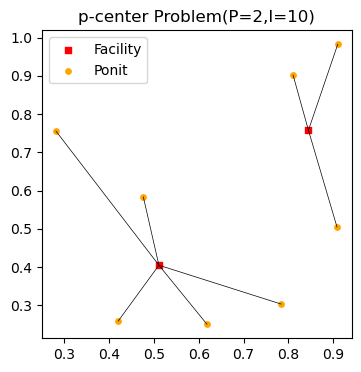

In [38]:
from itertools import product
from gurobipy import *
import numpy as np
from math import sqrt
import random
import matplotlib.pyplot as plt

# Parameters
num_points = 10
random.seed(0)
points = [(random.random(), random.random()) for i in range(num_points)]
num_located = 2  # P: number of located facility in the end
cartesian_prod = list(product(range(num_points), range(num_points))) 

# Compute distance
def compute_distance(loc1, loc2):
    dx = loc1[0] - loc2[0]
    dy = loc1[1] - loc2[1]
    return sqrt(dx*dx + dy*dy)
dist = {(i,j): compute_distance(points[i], points[j]) for i, j in cartesian_prod} # 用笛卡尔乘积遍历所有的配对

# Create a new model
m = Model("p-center Problem")

# Create variables
select = m.addVars(num_points, vtype=GRB.BINARY, name='Select') # X
assign = m.addVars(cartesian_prod, vtype=GRB.BINARY, name='Assign') # Y，用笛卡尔乘积快速创建多个决策变量
omega= m.addVar(lb=0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name='Omega') 

# Add constraints
m.addConstr((quicksum(select) == num_located), name='Num_limit')
m.addConstrs((assign[(i,j)] <= select[j] for i,j in cartesian_prod), name='Assign_before_locate')
m.addConstrs((quicksum(assign[(i,j)] for j in range(num_points)) == 1 for i in range(num_points)), name='Unique_assign')
m.addConstr((assign.prod(dist) <= omega), name='Min_distance')

# Set objective
m.setObjective(omega, GRB.MINIMIZE)

m.write("lp--p_center_Problem.lp")
m.optimize()

# Print results
selected = []
assigned = []
for i in select.keys():
    if select[i].x > 0:
        selected.append(i)
for i in assign.keys():
    if assign[i].x > 0:
        assigned.append(i)
print("Selected positions = ", selected)
print("Assigned relationships = ", assigned)
print('Min distance = %g' % m.objVal)

# Plot
node_facility = []
node_ponit = []
for key in select.keys():
    if select[key].x > 0:
        node_facility.append(points[key])
    else:
        node_ponit.append(points[key])

plt.figure(figsize=(4,4))
plt.title('p-center Problem(P=2,I=10)')
plt.scatter(*zip(*node_facility), c='Red', marker=',',s=20,label = 'Facility')   
plt.scatter(*zip(*node_ponit), c='Orange', marker='o',s=15, label = 'Ponit')
assignments = [p for p in assign.keys() if assign[p].x > 0.5]
for p in assignments:
    pts = [points[p[0]], points[p[1]]]
    plt.plot(*zip(*pts), c='Black', linewidth=0.5)

plt.grid(False)   
plt.legend(loc='best', fontsize = 10) 
plt.show() 

### 4、p-扩散问题（p-dispersion Problem）
假设有一个需求点的位置集合，且已知设施总数。在设施总数一定的前提下，确定在哪些需求点建造设施，使得所有需求点之间的距离最小值最大。

应用场景：发射井之间的距离越远，攻击者在一次打击中摧毁多个发射井的几率就越小。如果快餐加盟店分散在整个城市，总销售额可能会更高。

- 参数
$$
\begin{align*}
	&I\text{：需求位置集合}
	\\
	&P\text{：设施总数}
	\\
	&d_{ij}:\text{点}i\text{与点}j\text{之间的距离}
\end{align*}
$$
- 决策变量
$$
\begin{align*}
	D_{min} &=\text{一对节点之间的最短距离}\\
	X_{i} &=\begin{cases}
		1, \text{在}i\text{点建造设施}\\
		0\\
	\end{cases}\\
\end{align*}
$$

- IP模型
$$
\begin{align*}
\max  \; & D_{min}
\\
	s.t. \; & \sum_{i\in I}{X_i=P_i}	\\
	&X_jX_kd_{jk}\geqslant D_{min}X_jX_k && \forall j,k \in I\\
	&X_i \in \{0,1\} && \forall i \in I
\end{align*}
$$

通过引入逻辑约束，将 $X_jX_kd_{jk}\geqslant D_{min}X_jX_k $ 中两个0-1变量相乘的非线性项线性化后，可以转换为如下约束：
$$(2-X_j-X_k)M+d_{jk} \geqslant D_{min}, \quad j,k \in I$$

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 91 rows, 11 columns and 280 nonzeros
Model fingerprint: 0xad95d337
Variable types: 1 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+02]
Found heuristic solution: objective 0.6547424
Presolve removed 45 rows and 0 columns
Presolve time: 0.00s
Presolved: 46 rows, 11 columns, 145 nonzeros
Variable types: 1 continuous, 10 integer (10 binary)

Root relaxation: objective 1.601990e+02, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  155.80202    0    9    0.65474  155.80202      -     -    0s
H    0     0                       0.6747447  

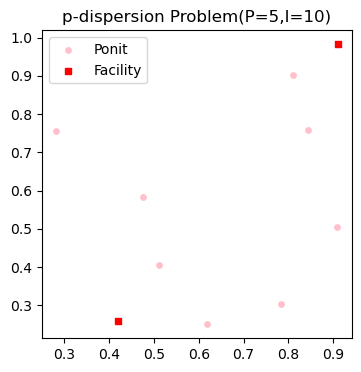

In [39]:
from itertools import product
from gurobipy import *
import numpy as np
from math import sqrt
import random
import matplotlib.pyplot as plt

# Parameters
num_points = 10
random.seed(0)
points = [(random.random(), random.random()) for i in range(num_points)]
num_located = 2  # P: number of located facility in the end
cartesian_prod = list(product(range(num_points), range(num_points)))
M = 100

# Compute distance
def compute_distance(loc1, loc2):
    dx = loc1[0] - loc2[0]
    dy = loc1[1] - loc2[1]
    return sqrt(dx*dx + dy*dy)
dist = {(i,j): compute_distance(points[i], points[j]) 
    for i, j in cartesian_prod
    if i != j }

# Create a new model
m = Model("p-dispersion Problem")

# Create variables
select = m.addVars(num_points, vtype=GRB.BINARY, name='Select') # X
D_min = m.addVar(lb=0, ub=GRB.INFINITY, obj=1, vtype=GRB.CONTINUOUS, name='D_min') 

# Add constraints
m.addConstr(quicksum(select) == num_located, name='Num_limit')
m.addConstrs(((2 - select[i] - select[j])* M + dist[i,j] >= D_min for i,j in cartesian_prod if i != j), name='Min_dist')
#m.addConstrs(((2 - select[i] - select[j])* M + (select[i] + select[j]) * dist[i,j] >= 2 * D_min for i,j in cartesian_prod if i != j), name='Min_dist')  # equal to the formula above

# Set objective
m.setObjective(D_min, GRB.MAXIMIZE) 

m.write("lp-p_dispersion_Problem.lp")
m.optimize()

# Print results
selected = []
for i in select.keys():
    if select[i].x > 0:
        selected.append(i)
print("Selected positions = ", selected)
print('D_min = %g' % D_min.x)

# Plot
facility = []
for key in select.keys():
    if select[key].x > 0:
        facility.append(points[key])

plt.figure(figsize=(4,4))
plt.title('p-dispersion Problem(P=5,I=10)')
plt.scatter(*zip(*points), c='Pink', marker='o',s=15, label = 'Ponit')
plt.scatter(*zip(*facility), c='Red', marker=',',s=20, label = 'Facility')   
plt.grid(False)   
plt.legend(loc='best', fontsize = 10) 
plt.show() 

### 5、p-中位问题（p-median problem）
假设有一个需求点的位置集合，且已知每个需求点的客户人数和设施总数。在设施总数一定的前提下，确定在哪些需求点建造设施，以及需求点与设施的对应分配关系，使得所有需求点的客户到达其所属设施的距离总和最小。

- 参数
$$
\begin{align*}
	&I\text{：需求位置集合}
	\\
    &h_i\text{：在i点的客户人数}
	\\
	&P\text{：设施总数}
	\\
	&d_{ij}:\text{点}i\text{与点}j\text{之间的距离}
\end{align*}
$$
- 决策变量
$$
\begin{align*}
	X_{i} &=\begin{cases}
		1, \text{在}i\text{点建造设施}\\
		0\\
	\end{cases}\\
	Y_{ij} &=\begin{cases}
		1, \text{点}i\text{分配给点}j\\
		0\\
	\end{cases}\\
\end{align*}
$$

- 整数规划模型
$$
\begin{align*}
	\min \quad &\sum_{i,j\in I}{h_id_{ij}Y_{ij}}
	\\
	s.t. \quad &\sum_{i\in I}{\begin{array}{c}
		\begin{array}{c}
		X_i=P\\
	\end{array}\\
	\end{array}}
	\\
	&Y_{ij}\leqslant X_j && \forall i,j \in I
	\\
	&\sum_{j\in J}{Y_{ij}=1} &&\forall i \in I
	\\
	&X_i, Y_{ij}\in \left\{ 0,1 \right\}  && \forall i,j \in I
\end{align*}
$$

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 111 rows, 110 columns and 310 nonzeros
Model fingerprint: 0x65ac48e4
Variable types: 0 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 12.1180054
Presolve time: 0.00s
Presolved: 111 rows, 110 columns, 310 nonzeros
Variable types: 0 continuous, 110 integer (110 binary)
Found heuristic solution: objective 6.0892403

Root relaxation: objective 5.409383e+00, 58 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       5.4093833    5.40938  0.00%     -    0s

Explored 1 nodes (58 simplex 

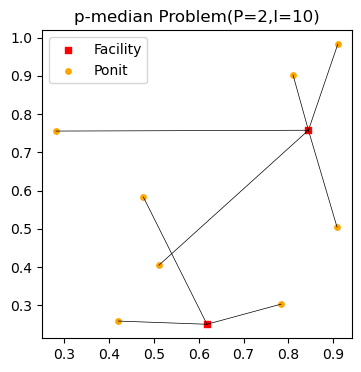

In [40]:
from itertools import product
from gurobipy import *
import numpy as np
from math import sqrt
import random
import matplotlib.pyplot as plt

# Parameters
num_points = 10
random.seed(0)
points = [(random.random(), random.random()) for i in range(num_points)]
num_located = 2  # P: number of located facility in the end
cartesian_prod = list(product(range(num_points), range(num_points)))
np.random.seed(0)
num_people = np.random.randint(6,size = num_points)  # h

# Compute distance
def compute_distance(loc1, loc2):
    dx = loc1[0] - loc2[0]
    dy = loc1[1] - loc2[1]
    return sqrt(dx*dx + dy*dy)
dist = {(i,j): compute_distance(points[i], points[j]) for i, j in cartesian_prod}

# Create a new model
m = Model("p-median Problem")

# Create variables
select = m.addVars(num_points, vtype=GRB.BINARY, name='Select') # X
assign = m.addVars(cartesian_prod, vtype=GRB.BINARY, name='Assign') # Y

# Add constraints
m.addConstr((quicksum(select) == num_located), name='Num_limit')
m.addConstrs((assign[i,j] <= select[j] for i,j in cartesian_prod), name='Assign_before_locate')
m.addConstrs((quicksum(assign[i,j] for j in range(num_points)) == 1 for i in range(num_points)), name='Unique_assign')

# Set objective
m.setObjective(quicksum(num_people[i]*dist[i,j]*assign[i,j] for i,j in cartesian_prod), GRB.MINIMIZE)

#m.write("lp--p_median_Problem.lp")
m.optimize()

# Print results
selected = []
assigned = []
for i in select.keys():
    if select[i].x > 0:
        selected.append(i)
for i in assign.keys():
    if assign[i].x > 0:
        assigned.append(i)
print("Selected positions = ", selected)
print("Assigned relationships = ", assigned)
print('Objvalue = %g' % m.objVal)

# Plot
node_facility = []
node_ponit = []
for key in select.keys():
    if select[key].x > 0:
        node_facility.append(points[key])
    else:
        node_ponit.append(points[key])

plt.figure(figsize=(4,4))
plt.title('p-median Problem(P=2,I=10)')
plt.scatter(*zip(*node_facility), c='Red', marker=',',s=20,label = 'Facility')   
plt.scatter(*zip(*node_ponit), c='Orange', marker='o',s=15, label = 'Ponit')
assignments = [p for p in assign.keys() if assign[p].x > 0.5]
for p in assignments:
    pts = [points[p[0]], points[p[1]]]
    plt.plot(*zip(*pts), c='Black', linewidth=0.5)

plt.grid(False)   
plt.legend(loc='best', fontsize = 10) 
plt.show()